In [11]:
import pandas as pd
import csv as csv
import os as os
from sklearn.model_selection import train_test_split

# Change working directory 
os.chdir('C:\Conestoga Projects\CSCN8010_MLF\Sustainable_AI\data')


In [10]:
df = pd.read_csv("energy_training_data.csv")

FEATURES = [
    "num_layers",
    "training_hours",
    "flops_per_hour",
    "prompt_tokens",
    "gpu_power_watts",
    "batch_size",
]
TARGET = "energy_kwh"

df.head()

,num_layers,training_hours,flops_per_hour,prompt_tokens,gpu_power_watts,batch_size,energy_kwh
0,21,3.036058,1.180361e+08,189,310.323046,77,2.857136
1,25,45.526522,4.491940e+07,270,277.679971,33,5.414321
2,10,30.477541,1.309254e+08,175,133.931910,145,5.114819
3,61,29.960245,1.338420e+08,511,305.704786,188,6.623944
4,32,18.246479,5.337145e+07,422,146.572406,38,4.476142


In [12]:

X = df[FEATURES].values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=2825
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (800, 6)
Test shape : (200, 6)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_regression_model(model, X_train, y_train, X_test, y_test, name="model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)   # no 'squared' arg here
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    print(f"[{name}]")
    print(f"  MAE : {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²  : {r2:.4f}")
    
    return {"mae": mae, "rmse": rmse, "r2": r2}, y_pred

lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=2825,
    n_jobs=-1
)

metrics_lin, y_pred_lin = evaluate_regression_model(
    lin_reg, X_train, y_train, X_test, y_test, name="LinearRegression"
)

metrics_rf, y_pred_rf = evaluate_regression_model(
    rf_reg, X_train, y_train, X_test, y_test, name="RandomForestRegressor"
)


[LinearRegression]
  MAE : 0.5606
  RMSE: 0.7054
  R²  : 0.7721
[RandomForestRegressor]
  MAE : 0.6373
  RMSE: 0.8102
  R²  : 0.6994


In [15]:
if metrics_lin["rmse"] <= metrics_rf["rmse"]:
    best_model = lin_reg
    best_name = "LinearRegression"
    y_pred_best = y_pred_lin
else:
    best_model = rf_reg
    best_name = "RandomForestRegressor"
    y_pred_best = y_pred_rf

print("Selected best model:", best_name)


Selected best model: LinearRegression


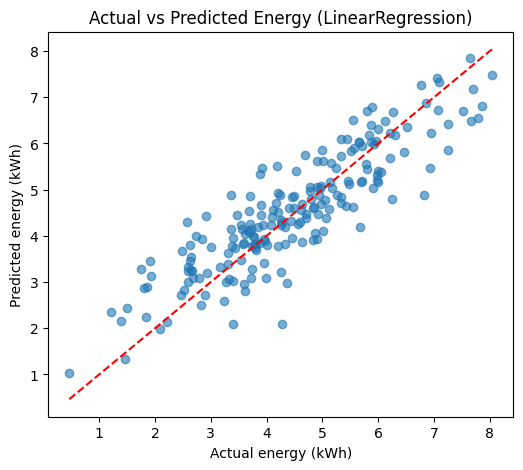

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.xlabel("Actual energy (kWh)")
plt.ylabel("Predicted energy (kWh)")
plt.title(f"Actual vs Predicted Energy ({best_name})")

min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.show()


In [17]:
import os
import joblib

MODEL_DIR = "model"
ENERGY_MODEL_DIR = os.path.join(MODEL_DIR, "energy_predictor")
os.makedirs(ENERGY_MODEL_DIR, exist_ok=True)

energy_model_path = os.path.join(ENERGY_MODEL_DIR, "energy_predictor.pkl")
joblib.dump(best_model, energy_model_path)

print("Saved energy model to:", energy_model_path)


Saved energy model to: model\energy_predictor\energy_predictor.pkl


In [18]:
#Create a helper function predict_energy(...)

#This will be used later when the user gives you a prompt + config:

import numpy as np
import joblib

def load_energy_model(path: str = energy_model_path):
    return joblib.load(path)

def predict_energy(
    num_layers: int,
    training_hours: float,
    flops_per_hour: float,
    prompt_tokens: int,
    gpu_power_watts: float,
    batch_size: int,
    model=None,
) -> float:
    """
    Predict energy consumption (kWh) for a given configuration.
    """
    if model is None:
        model = load_energy_model()
    
    X_input = np.array([[
        num_layers,
        training_hours,
        flops_per_hour,
        prompt_tokens,
        gpu_power_watts,
        batch_size,
    ]], dtype=float)
    
    return float(model.predict(X_input)[0])


In [19]:
#sample test data
test_energy = predict_energy(
    num_layers=24,
    training_hours=10.0,
    flops_per_hour=8e7,
    prompt_tokens=200,
    gpu_power_watts=250,
    batch_size=64,
)
print("Predicted energy (kWh):", test_energy)


Predicted energy (kWh): 2.8993126942300775


In [22]:
# Using a Deep learning model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

X_train_dl = X_train  # same features
y_train_dl = y_train
X_val_dl = X_test
y_val_dl = y_test

model_dl = keras.Sequential([
    layers.Input(shape=(X_train_dl.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # energy_kwh
])

model_dl.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

history = model_dl.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=50,
    batch_size=32,
    verbose=0
)
